# Denoising Diffusion Probabilistic Models with M&Ms-2 Dataset

This tutorial illustrates how to use MONAI for training a denoising diffusion probabilistic model (DDPM)[1] to create
synthetic 2D images.

[1] - Ho et al. "Denoising Diffusion Probabilistic Models" https://arxiv.org/abs/2006.11239


## Setup environment

In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import time
import torchio

from monai import transforms
from monai import handlers
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.utils import first, set_determinism

from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDIMScheduler, DDPMScheduler, PNDMScheduler

print_config()
print("TorchIO version:", torchio.__version__)

c:\Users\shuang07\Anaconda3\envs\ddpm\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2023-04-24 14:28:00,417 - WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 1.13.1+cu117 with CUDA 1107 (you have 1.13.1+cpu)
    Python  3.10.9 (you have 3.10.10)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
MONAI version: 1.2.dev2304
Numpy version: 1.24.1
Pytorch version: 1.13.1+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 9a57be5aab9f2c2a134768c0c146399150e247a0
MONAI __file__: c:\Users\shuang07\Anaconda3\envs\ddpm\lib\site-packages\monai_weekly-1.2.dev2304-py3.10.egg\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
ITK version: 5.3.0
Nibabel version: 5.0.1
scikit-image version: 0.20.0
Pillow version: 9.4.0
Tensorboard version: 2.12.2
gdown version: 4.7.1
TorchVision version: 0.14.1+cpu
tqdm vers

## Setup data directory

You can specify a directory with the MONAI_DATA_DIRECTORY environment variable.

This allows you to save results and reuse downloads.

If not specified a temporary directory will be used.

In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

C:\Users\shuang07\AppData\Local\Temp\tmpc8km1uoo


## Set deterministic training for reproducibility

In [3]:
set_determinism(42)

## Setup M&Ms-2 Dataset and training and validation dataloaders
Combine Sina's implementation to import M&Ms-2 dataset (https://www.ub.edu/mnms-2/) manually.

In [4]:
from modules.dataloader import CMRCineDataModule
import argparse
import sys
sys.argv=['']
del sys
import os
import warnings
warnings.filterwarnings('ignore')

PATH = os.path.join(os.getcwd(), "dataset_3D_crop_small")
RUN_NAME = "cmr_DDPM_24042023"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print('Device is {}'.format(DEVICE))
# print("Current device is on", torch.cuda.current_device())
# print(torch.cuda.get_device_name(0))

# set your own path here, eg, '/home/bme001/20180883/data/mnms2/sorted/SA/PerDisease' (Linux style path)
default_config = {
    'dataset_path': PATH,
    'run_name': RUN_NAME,
    'epochs': 1,
    'log_interval': 100,
    'batch_size' : 8,
    'image_size' : 64,
    'num_workers' : 0,  # default 8, windows cannot handle this
    'device' : DEVICE,
    'lr' : 3e-4,
    'noise_steps' : 1000,
    'beta_start': 1e-4,
    'beta_end': 0.02,
    }

# set key-value pairs from command line 
parser = argparse.ArgumentParser()
for keys in default_config:
    parser.add_argument('--'+keys, default=default_config[keys], type= type(default_config[keys]))
args = parser.parse_args()

# CMR2DDataModule or CMRCineDataModule class
data = CMRCineDataModule(
        data_dir = args.dataset_path,
        image_size = args.image_size,
        batch_size = args.batch_size,
        train_val_ratio = 0.8,
        num_workers = args.num_workers,
    )
data.prepare_data()
data.setup()

train_loader = data.train_dataloader()
val_loader = data.val_dataloader()

print(train_loader.dataset.__len__())
print(val_loader.dataset.__len__())

Device is cpu
40
10


In [5]:
print('Batch_size = {}'.format(args.batch_size))
print('Number of batches in train_dataloader = {}'.format(len(train_loader)))
print('Number of batches in val_dataloader = {}'.format(len(val_loader)))

batch = next(iter(train_loader))

# The dictionary is not needed for the training but not first priority to remove it
print(batch['image']['data'].squeeze(-1).shape)
print(batch['image']['data'].squeeze(-1).max())
print(batch['image']['data'].squeeze(-1).min())

Batch_size = 8
Number of batches in train_dataloader = 5
Number of batches in val_dataloader = 2
torch.Size([8, 1, 64, 64])
tensor(0.6754)
tensor(-1.)


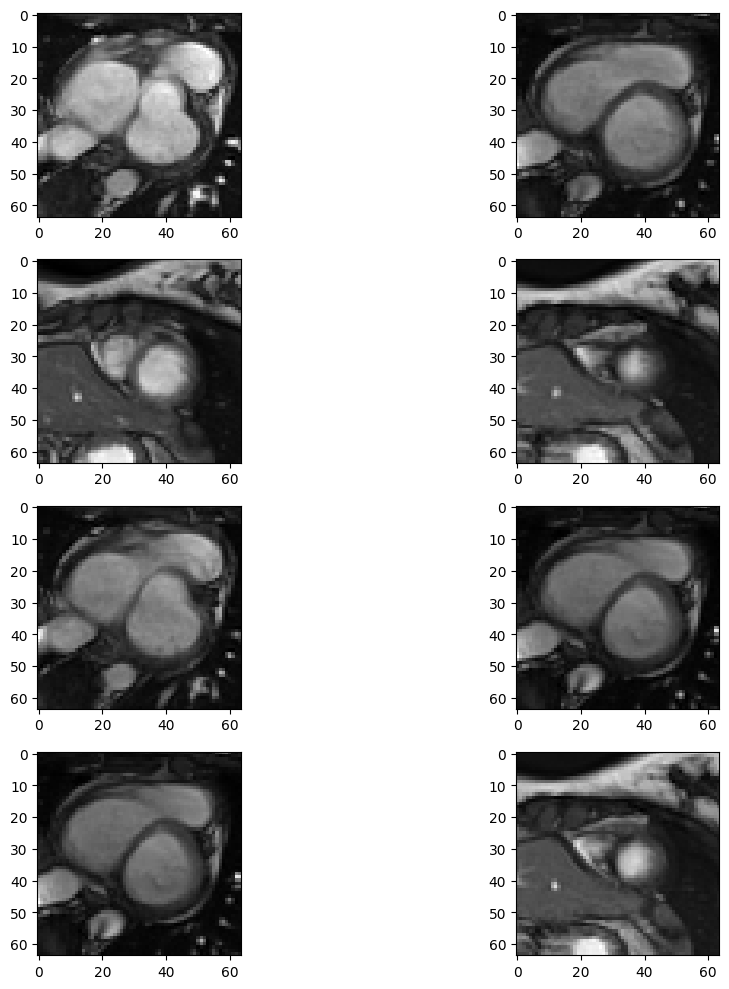

In [6]:
from modules.utils import plot_batch

# TODO: Filter out the useless slices
plot_batch(train_loader)

### Visualisation of the training images

batch shape: torch.Size([8, 1, 64, 64, 1])
torch.Size([64, 64, 1])
tensor(0.6157)
tensor(-0.9155)


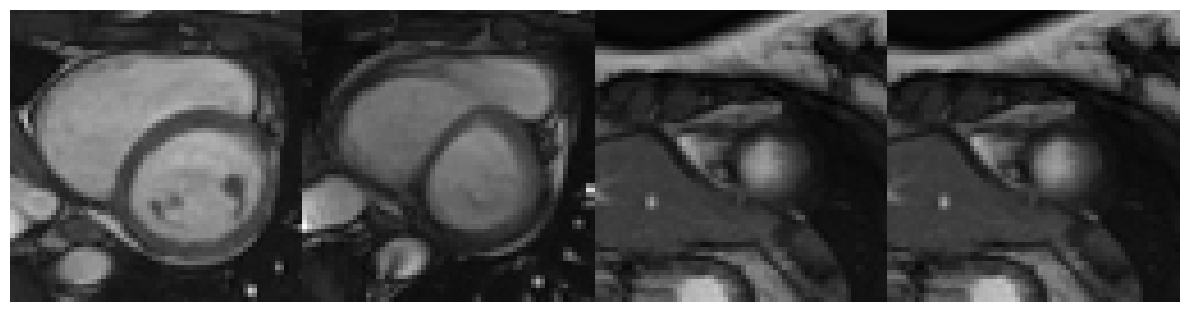

In [31]:
check_data = first(train_loader)
print(f"batch shape: {check_data['image']['data'].shape}")
# print(check_data["image"]['data'][0, 0].shape)
image_visualisation = torch.cat(
    [check_data["image"]['data'][0, 0], check_data["image"]['data'][1, 0], \
        check_data["image"]['data'][2, 0], check_data["image"]['data'][3, 0]], dim=1
)
print(check_data["image"]['data'][0, 0].max())
print(check_data["image"]['data'][0, 0].min())
plt.figure("training images", (12, 6))
plt.imshow(image_visualisation, vmin=-1, vmax=1, cmap="gray")  
# plt.imshow(image_visualisation, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

### Define network, scheduler, optimizer, and inferer
At this step, we instantiate the MONAI components to create a DDPM, the UNET, the noise scheduler, and the inferer used for training and sampling. We are using
the original DDPM scheduler containing 1000 timesteps in its Markov chain, and a 2D UNET with attention mechanisms
in the 2nd and 3rd levels, each with 1 attention head.

In [8]:
# set up the model
device = torch.device(args.device)
total_timesteps = args.noise_steps
epochs = args.epochs

model = DiffusionModelUNet(
    spatial_dims = 2,
    in_channels = 1,
    out_channels = 1,
    num_channels = (128, 256, 256),
    attention_levels = (False, True, True),
    num_res_blocks = 1,
    num_head_channels = 256,
)
model.to(device)

scheduler = DDPMScheduler(num_train_timesteps=total_timesteps)

optimizer = torch.optim.Adam(params=model.parameters(), lr=args.lr)

inferer = DiffusionInferer(scheduler)

In [9]:
assert False

AssertionError: 

### Model training
If you would like to skip the training and use a pre-trained model instead, set `use_pretrained=True`. This model was trained using the code in `tutorials/generative/distributed_training/ddpm_training_ddp.py`

In [ ]:
# import requests
# from urllib3.exceptions import InsecureRequestWarning
# from urllib3 import disable_warnings

# disable_warnings(InsecureRequestWarning)

# page = requests.get('https://drive.google.com', verify=False)

# print(page.content)

In [32]:
# TODO: Sovle the problem with the pretrained model
use_pretrained = True  # set to False to train the model from scratch

# TODO: Solve the problem CPU bottleneck, eg. ChacheDataset https://www.youtube.com/watch?v=0mVgu_DFbeY
if use_pretrained:
    model = torch.hub.load("marksgraham/pretrained_generative_models:v0.2", model="ddpm_2d", verbose=True).to(device)
else:
    n_epochs = epochs
    val_interval = 20
    epoch_loss_list = []
    val_epoch_loss_list = []

    scaler = GradScaler()
    total_start = time.time()
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
        progress_bar.set_description(f"Epoch {epoch}")
        for step, batch in progress_bar:
            images = batch["image"]['data'].squeeze(-1).to(device)
            optimizer.zero_grad(set_to_none=True)

            with autocast(enabled=True):
                # Generate random noise
                noise = torch.randn_like(images).to(device)

                # Create timesteps
                timesteps = torch.randint(
                    0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                ).long()

                # Get model prediction
                noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)

                loss = F.mse_loss(noise_pred.float(), noise.float())

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()

            progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
        epoch_loss_list.append(epoch_loss / (step + 1))

        # if (epoch + 1) % val_interval == 0:
        if True:
            model.eval()
            val_epoch_loss = 0
            for step, batch in enumerate(val_loader):
                images = batch["image"]['data'].squeeze(-1).to(device)
                with torch.no_grad():
                    with autocast(enabled=True):
                        noise = torch.randn_like(images).to(device)
                        timesteps = torch.randint(
                            0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                        ).long()
                        noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                        val_loss = F.mse_loss(noise_pred.float(), noise.float())

                val_epoch_loss += val_loss.item()
                progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
            val_epoch_loss_list.append(val_epoch_loss / (step + 1))

            # Sampling image during training
            noise = torch.randn((1, 1, 64, 64))
            noise = noise.to(device)
            scheduler.set_timesteps(num_inference_steps=total_timesteps)
            with autocast(enabled=True):
                image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler)

            plt.figure(figsize=(2, 2))
            plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
            plt.tight_layout()
            plt.axis("off")
            plt.show()

    total_time = time.time() - total_start
    print(f"train completed, total time: {total_time}.")

Downloading: "https://github.com/marksgraham/pretrained_generative_models/zipball/v0.2" to C:\Users\shuang07/.cache\torch\hub\v0.2.zip
Downloading...
From (uriginal): https://drive.google.com/uc?export=download&id=1UTaeBMHIFxQDxWMoQNqSffGhbUDVRatZ
From (redirected): https://drive.google.com/uc?export=download&id=1UTaeBMHIFxQDxWMoQNqSffGhbUDVRatZ&confirm=t&uuid=5ca40ff1-ef59-4549-b6da-c4099b7d1ea7
To: C:\Users\shuang07\.cache\torch\hub\checkpoints\ddpm_2d_v2.pth
100%|██████████| 74.1M/74.1M [00:04<00:00, 17.2MB/s]


### Save the trained model

In [35]:
PATH = os.path.join(os.getcwd(), "checkpoints/checkpoints_T1000_test")
torch.save(model.state_dict(), PATH)

In [36]:
# Initialize the model
model = DiffusionModelUNet(
    spatial_dims = 2,
    in_channels = 1,
    out_channels = 1,
    num_channels = (128, 256, 256),
    attention_levels = (False, True, True),
    num_res_blocks = 1,
    num_head_channels = 256,
)
model.to(device)

DiffusionModelUNet(
  (conv_in): Convolution(
    (conv): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (time_embed): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock(
      (resnets): ModuleList(
        (0): ResnetBlock(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (nonlinearity): SiLU()
          (conv1): Convolution(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv2): Convolution(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (skip_connection): Identity()
        )
      )
      (downsampler): Downsample(
    

### Load the trained model

In [38]:
PATH = os.path.join(os.getcwd(), "checkpoints/checkpoints_T1000_test")
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

### Learning curves

In [ ]:
if not use_pretrained:
    plt.style.use("seaborn-v0_8")
    plt.title("Learning Curves", fontsize=20)
    plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_loss_list, color="C0", linewidth=2.0, label="Train")
    plt.plot(
        np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)),
        val_epoch_loss_list,
        color="C1",
        linewidth=2.0,
        label="Validation",
    )
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel("Epochs", fontsize=16)
    plt.ylabel("Loss", fontsize=16)
    plt.legend(prop={"size": 14})
    plt.show()

### Plotting sampling process along DDPM's Markov chain

100%|██████████| 1000/1000 [06:00<00:00,  2.77it/s]


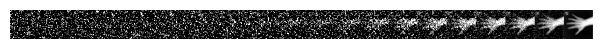

In [39]:
model.eval()
noise = torch.randn((1, 1, 64, 64))
noise = noise.to(device)
scheduler.set_timesteps(num_inference_steps=total_timesteps)
with autocast(enabled=True):
    image, intermediates = inferer.sample(
        input_noise=noise, diffusion_model=model, scheduler=scheduler, save_intermediates=True, intermediate_steps=50
    )

chain = torch.cat(intermediates, dim=-1)

plt.style.use("default")
plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()